# Monetary Policy and Markets

Plotting Finantial Market and Monetary Policy data.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.dates import DayLocator, MonthLocator, DateFormatter
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

# path for the folder "project"
path = "C:\\Users\\pedro\\OneDrive\\NYU\\CSS\\II. Data Skills\\project"
os.chdir(path)

# colors
colors = [
    '#1B4F72','#D35400','#16A05D','#DC2F1D','#3498DB','#9C9C9C','#F39C12','#28B463','#EC7063','#F1C40F',  # custom
    '#641E16','#7B241C','#922B21','#A93226','#C0392B','#CD6155','#D98880','#E6B0AA','#F2D7D5','#F9EBEA',  # dark red
    '#78281F','#943126','#B03A2E','#CB4335','#E74C3C','#EC7063','#F1948A','#F5B7B1','#FADBD8','#FDEDEC',  # red
    '#154360','#1A5276','#1F618D','#2471A3','#2980B9','#5499C7','#7FB3D5','#A9CCE3','#D4E6F1','#EAF2F8',  # dark blue
    '#1B4F72','#21618C','#2874A6','#2E86C1','#3498DB','#5DADE2','#85C1E9','#AED6F1','#D6EAF8','#EBF5FB',  # blue
    '#145A32','#196F3D','#1E8449','#229954','#27AE60','#52BE80','#7DCEA0','#A9DFBF','#D4EFDF','#E9F7EF',  # dark green
    '#0B5345','#0E6655','#117A65','#138D75','#16A085','#45B39D','#73C6B6','#A2D9CE','#D0ECE7','#E8F6F3',  # green
    '#6E2C00','#873600','#A04000','#BA4A00','#D35400','#DC7633','#E59866','#EDBB99','#F6DDCC','#FBEEE6',  # dark orange
    '#784212','#935116','#AF601A','#CA6F1E','#E67E22','#EB984E','#F0B27A','#F5CBA7','#FAE5D3','#FDF2E9',  # orange
    '#7D6608','#9A7D0A','#B7950B','#D4AC0D','#F1C40F','#F4D03F','#F7DC6F','#F9E79F','#FCF3CF','#FEF9E7',  # yellow
    '#626567','#797D7F','#909497','#A6ACAF','#BDC3C7','#CACFD2','#D7DBDD','#E5E7E9','#F2F3F4','#F8F9F9']  # gray


plt.style.use('seaborn-bright')
plt.rcParams['figure.dpi'] = 200 # high quality figure.
%matplotlib inline

## Functions

Writting functions to transform and plot data.  
For more details about the functions, take a look at the `charts_inflation` notebook.

In [2]:
# creating function to calculate percent changes.
def compute_change(x, n, dt = "date", series="series_id", value = "value"):
    """
    Calculates yoy changes for different groups in the Data Frame.
    ---
    paramns:
        x: pandas dataframe with date, series_id and values columns.
        n: int representing the percent change period. (n=12 for YoY, n=1 for MoM)
        dt: dates column name
        series: series_id column name
        value: values column name
    
    returns: pandas data frame with yoy changes by group in the original value column.
    """
    return (x
            .sort_values(dt)
            .set_index([dt, series])
            .groupby(pd.Grouper(level = series))[value]
            .pct_change(periods = n)
            .dropna()
            .reset_index()
            .eval(f"{value} = {value}*100"))


# function to calculate monthly annual change rates.
def saar(x, n, dt = "date", series="series_id", value = "value"):
    """
    Calculates monthly annual rate changes
    ---
    paramns:
        x: pandas dataframe with date, series id and values columns
        n: [int] Number of months
        dt: [str] dates column name
        series: [str] series_id column name
        value: [str] values column name
    
    returns: pandas series with yoy changes by group.
    """
    x = (x
         .sort_values(dt)
         .set_index(dt)
         .groupby(series)[value]
         .rolling(n)
         .mean()
         .dropna()
         .reset_index())
    
    x = (x
         .sort_values(dt)
         .set_index([dt, series])
         .groupby(pd.Grouper(level = series))[value]
         .pct_change(periods = n)
         .dropna()
         .reset_index()
         .eval(f"{value} = {value}+1")
         .eval(f"{value} = ({value}**{12/n} -1) * 100"))
      
    return x

In [3]:
# function to plot time series data.
def ts_plot(df, df_map, start_date, title, ylab,
            fig_size = (12,6), legend_loc = "upper left",
            plot_recession = True, plot_zero = True,
            xmargin = 0.01, ymargin = 0.04,
            y_major_loc = 2, y_minor_loc = 2,
            x_major_loc = 48, x_minor_loc = 2, x_format = "%Y", n = 0):
    """
    Time Series Plot that consumes a DataFrame in the long format, with
    columns series_id, date and value.
    ----
    Params:
        df: The long format pandas dataframe.
        df_map: data frame with series id, color code,
                alpha [0,1] and annotation (True or False).
        start_date: [srt] date the chart should start.
        title: [str] chart title.
        ylab: [str] y axis title.
        n: [int] additional space (in days) at the right side of the chart.
        Others:
             
        
    ----
    Returns:
        figure and axes objects.
    """
    
    # starting plot
    fig, ax = plt.subplots(figsize = fig_size)
    
    # filter date
    df = df[df["date"] >= start_date]
        
    # last observation
    last = df.groupby("series_id")["date"].max().reset_index()
    last = pd.merge(last,df,how="left", on=["series_id","date"])
    
    # line plot using seaborn and annotation
    for i in range(len(df_map)):
    
        sns.lineplot(
            data=df[df["series_id"]==df_map.loc[i][0]], #filter series
            x="date", y="value",
            color=df_map.loc[i][1], # map color
            alpha = df_map.loc[i][2], # map alpha
            ax=ax, legend=False)
    
        if df_map.loc[i][3] == True:
            ax.annotate(text = round(last.loc[last["series_id"] == df_map.loc[i][0], "value"].values[0],1),
                        xy = (last.loc[last["series_id"] == df_map.loc[i][0], "date"],
                              last.loc[last["series_id"] == df_map.loc[i][0], "value"]),
                        xycoords = "data", xytext = (1,0), textcoords="offset points",
                        color = df_map.loc[i][1], alpha = df_map.loc[i][2],
                        size='small', stretch="ultra-expanded",weight="semibold")
    
    # adding legend
    ax.legend(list(df_map["series_id"].values), 
        loc= legend_loc, frameon=True, framealpha=0.9, fontsize='small')
    
    # plotting recessions
    if plot_recession == True:
        
        recessions = pd.DataFrame({
                'start': ['1948-11-01', '1953-07-01', '1957-08-01', '1960-04-01', '1969-12-01', '1973-11-01', '1980-01-01', 
                '1981-07-01', '1990-07-01', '2001-03-01', '2007-12-01', '2020-02-01'],
                'end': ['1949-10-01', '1954-05-01', '1958-04-01', '1961-02-01', '1970-11-01', '1975-03-01', '1980-07-01', 
                '1982-11-01', '1991-03-01', '2001-11-01', '2009-06-01', '2020-06-01']
            })
        
        recessions["start"] = pd.to_datetime(recessions["start"])
        recessions["end"] = pd.to_datetime(recessions["end"])
        
        recessions = recessions[recessions["start"]>=start_date]
        
        # plotting
        for i in range(recessions.shape[0]):
            ax.axvspan(recessions.iloc[i]["start"], recessions.iloc[i]["end"],
                       ec=None, color=colors[100], alpha=0.3)
    
    if plot_zero == True:
        
        # adding gray line at zero:
        ax.axhline(y=0, color='gray', lw=0.8)
    
    # 1% margin at date axis, and 4% in y axis:
    ax.margins(x=xmargin, y=ymargin)
    
    # y axis
    ax.set_ylabel(ylab, size='medium')
    ax.yaxis.set_major_locator(MultipleLocator(y_major_loc))
    ax.yaxis.set_minor_locator(AutoMinorLocator(y_minor_loc))
    
    # date axis
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=x_major_loc))
    ax.xaxis.set_minor_locator(AutoMinorLocator(x_minor_loc))
    
    year_month_formatter = mdates.DateFormatter(x_format)
    ax.xaxis.set_major_formatter(year_month_formatter)
    
    # dropping top and right spines.
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    ax.spines['top'].set_edgecolor(colors[107])
    ax.spines['right'].set_edgecolor(colors[107])

    # grid lines
    ax.grid(axis='y', alpha=0.3)
    ax.grid(axis='x', alpha=0.3)
    
    # adjusting x axis limits
    ax.set_xlim([pd.to_datetime(start_date),pd.to_datetime(df["date"].max()) + pd.Timedelta(days=n)])
    
    # adding title
    ax.set_title(title, y=1.05, loc="center",
                fontweight="bold")
    
    # subtitle (Improvising here)
    # With a lot of data sources,
    # plotting the last observation date is a good way to check if everything is being updated.
    ax.xaxis.set_label_position('top')
    sub = last["date"].dt.strftime("%B, %Y").max()
    ax.set_xlabel(f"last update: {sub}",labelpad = 8, loc="center")
    
    return fig, ax


In [4]:
# function to plot time series data with two y-axis.
def dual_ts_plot(df, series1, series2, start_date, title, ly_label, ry_label,
                 fig_size = (12,6), legend_loc = "upper left",
                 plot_recession = True, plot_zero = True,
                 xmargin = 0.01, ymargin = 0.04,
                 y_major_loc = 2, y_minor_loc = 2,
                 x_major_loc = 48, x_minor_loc = 2, x_format = "%Y", n = 0):
    """
    Time Series Plot that consumes a DataFrame in the long format, with
    columns series_id, date and value.
    ----
    Params:
        df: The long format pandas dataframe.
        df_map: data frame with series id, color code,
                alpha [0,1] and annotation (True or False).
        start_date: [srt] date the chart should start.
        title: [str] chart title.
        ylab: [str] y axis title.
        n: [int] additional space (in days) at the right side of the chart.
        Others:
             
        
    ----
    Returns:
        figure and axes objects.
    """
    
    # starting plot
    fig, ax = plt.subplots(figsize = fig_size)
    
    # filter date
    df = df[df["date"] >= start_date]
        
    # inside the function:
    data1 = df[df["series_id"]==series1].copy()
    data2 = df[df["series_id"]==series2].copy()
    
    mean1 = np.mean(data1["value"])
    sd1 = np.std(data1["value"])
    
    mean2 = np.mean(data2["value"])
    sd2 = np.std(data2["value"])
    
    data2["value"] = ((data2["value"] - mean2)/sd2)*sd1 + mean1
    
    # line plot using seaborn
    sns.lineplot(data=data1,
                 x="date", y="value",
                 color=colors[0], ax=ax, legend=False)
    
    sns.lineplot(data=data2,
                 x="date", y="value", color=colors[1], ax=ax, legend=False)
    
    ax2 = ax.twinx()
    
    y1, y2 = ax.get_ylim()
    ax2.set_ylim(sd2*((y1-mean1)/sd1)+mean2, sd2*((y2-mean1)/sd1)+mean2)
        
    # adding legend
    ax.legend([ly_label, ry_label],
              loc= legend_loc, frameon=True, framealpha=0.9, fontsize='small')
    
    # plotting recessions
    if plot_recession == True:
        
        recessions = pd.DataFrame({
                'start': ['1948-11-01', '1953-07-01', '1957-08-01', '1960-04-01', '1969-12-01', '1973-11-01', '1980-01-01', 
                '1981-07-01', '1990-07-01', '2001-03-01', '2007-12-01', '2020-02-01'],
                'end': ['1949-10-01', '1954-05-01', '1958-04-01', '1961-02-01', '1970-11-01', '1975-03-01', '1980-07-01', 
                '1982-11-01', '1991-03-01', '2001-11-01', '2009-06-01', '2020-06-01']
            })
        
        recessions["start"] = pd.to_datetime(recessions["start"])
        recessions["end"] = pd.to_datetime(recessions["end"])
        
        recessions = recessions[recessions["start"]>=start_date]
        
        # plotting
        for i in range(recessions.shape[0]):
            ax.axvspan(recessions.iloc[i]["start"], recessions.iloc[i]["end"],
                       ec=None, color=colors[100], alpha=0.3)
    
    if plot_zero == True:
        
        # adding gray line at zero:
        ax.axhline(y=0, color='gray', lw=0.8)
    
    # 1% margin at date axis, and 4% in y axis:
    ax.margins(x=xmargin, y=ymargin)
    
    # y axis
    ax.set_ylabel(ly_label, size='medium')
    ax.yaxis.set_major_locator(MultipleLocator(y_major_loc))
    ax.yaxis.set_minor_locator(AutoMinorLocator(y_minor_loc))
    ax2.set_ylabel(ry_label, size='medium')
    
    # date axis
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=x_major_loc))
    ax.xaxis.set_minor_locator(AutoMinorLocator(x_minor_loc))
    
    year_month_formatter = mdates.DateFormatter(x_format)
    ax.xaxis.set_major_formatter(year_month_formatter)
    
    # dropping top and right spines.
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    ax.spines['top'].set_edgecolor(colors[107])
    ax2.spines['top'].set_edgecolor(colors[107])

    # grid lines
    ax.grid(axis='y', alpha=0.3)
    ax.grid(axis='x', alpha=0.3)
    
    # adjusting x axis limits
    ax.set_xlim([pd.to_datetime(start_date), pd.to_datetime(df["date"].max()) + pd.Timedelta(days=n)])
    
    # adding title
    ax.set_title(title, y=1.05, loc="center",
                fontweight="bold")
    
    # subtitle (Improvising here)
    # With a lot of data sources,
    # plotting the last observation date is a good way to check if everything is being updated.
    ax.xaxis.set_label_position('top')
    sub = df["date"].max().strftime("%B, %Y")
    ax.set_xlabel(f"last update: {sub}", labelpad = 8, loc="center")
    
    return fig, ax



## Importing Data

In [5]:
# Monetary Policy data:
ffunds = pd.read_parquet("data\\monetary_market\\data_fred_fed_funds.parquet")
fassets = pd.read_parquet("data\\monetary_market\\data_fred_fed_assets.parquet")
hh_netwoth = pd.read_parquet("data\\monetary_market\\data_fred_households_networth.parquet")

# Market data:
snp = pd.read_parquet("data\\monetary_market\\data_yf_snp500.parquet")
treasury = pd.read_parquet("data\\monetary_market\\data_fred_treasury_yields.parquet")
breakeven = pd.read_parquet("data\\monetary_market\\data_fred_breakeven_rates.parquet")

## Charts Policy

- Fed Funds Rate
- Fed Balance Sheet
- Treasury Yields
- 10y - 2y and NY fed model (to do)
- Breakevens
- 5y5y and oil (to do)
- S&P500 (import from quandl)
- S&P500 x Households networth (to do)

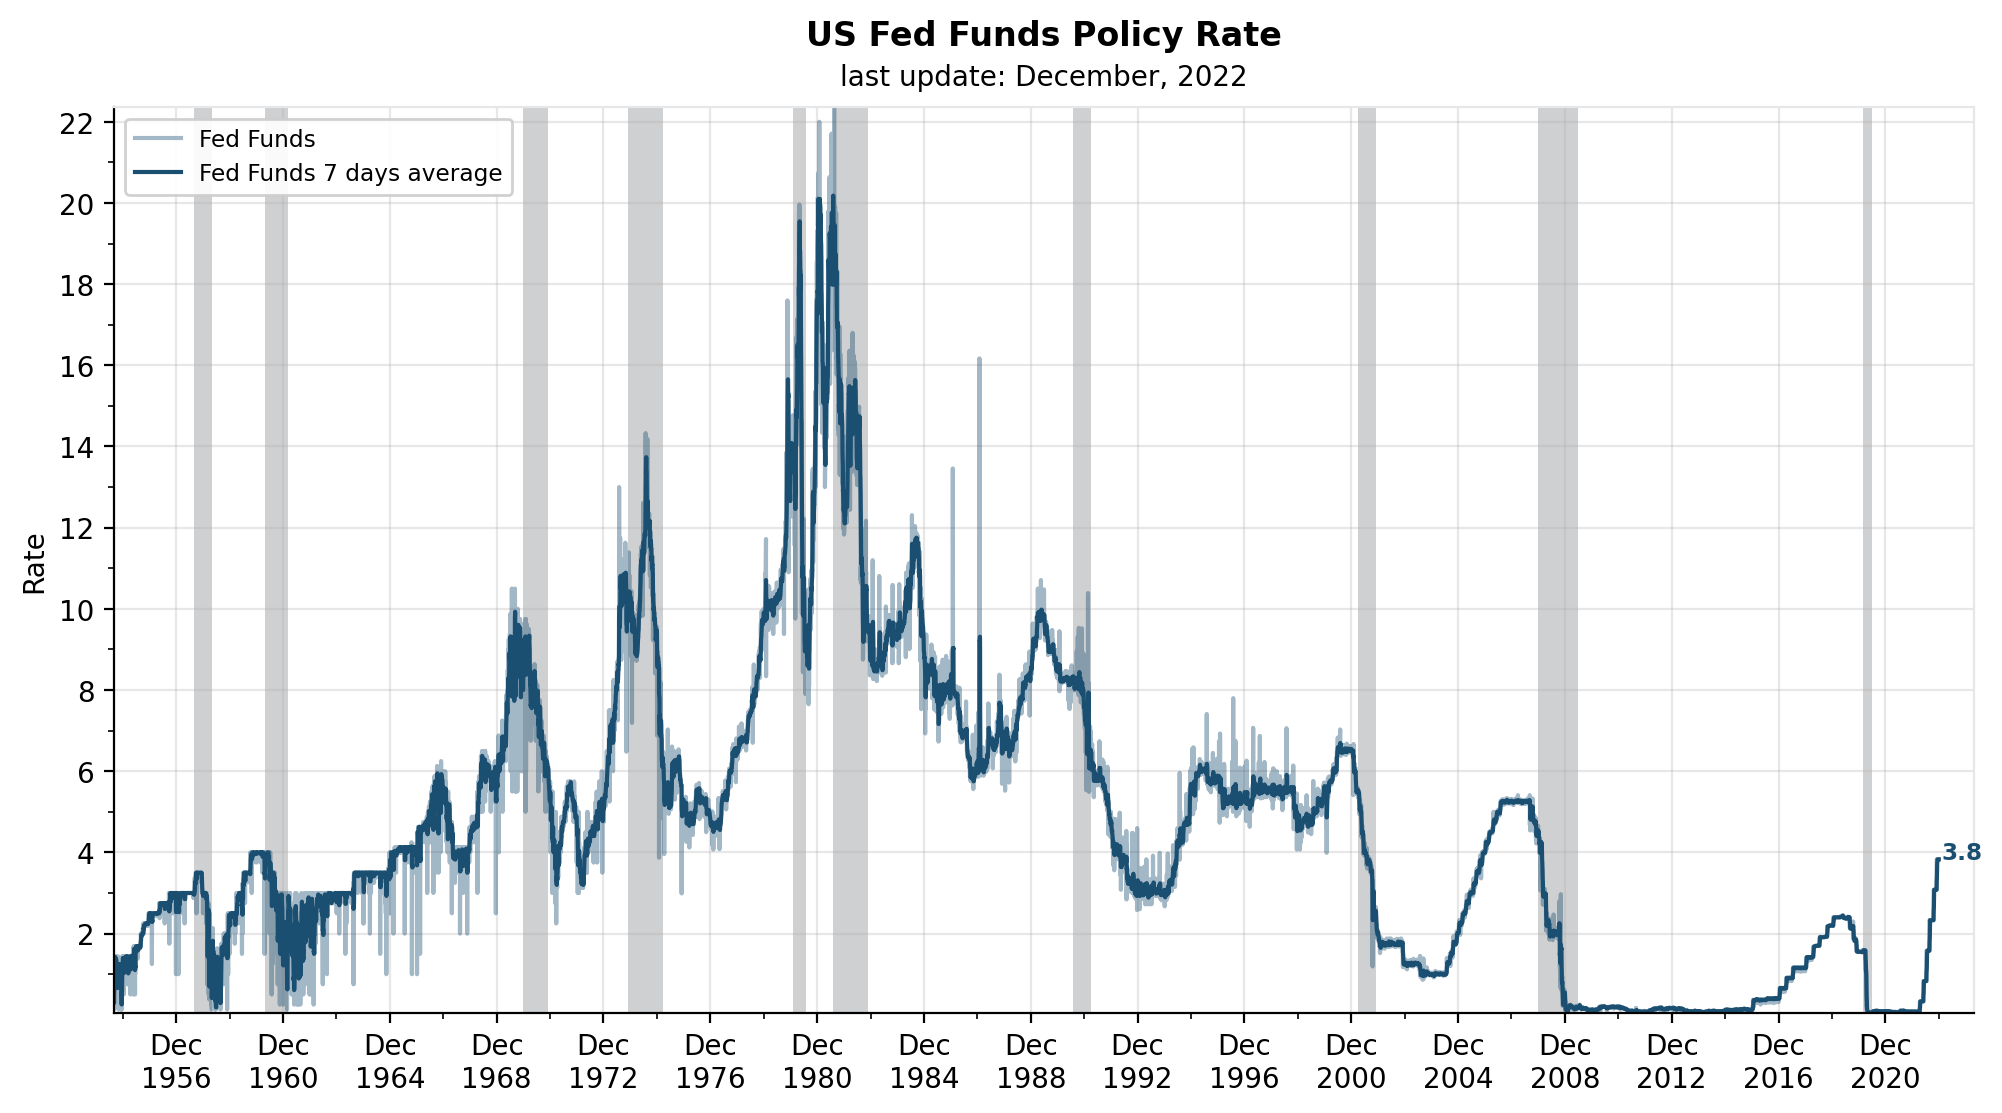

In [43]:
# Fed Funds
data = (
    ffunds[ffunds["series_id"]=="RIFSPFFNB"]
    .copy()
    .replace("RIFSPFFNB","Fed Funds")
    [["series_id","date","value"]]
)

data_ma = (data
           .copy()
           .sort_values("date")
           .set_index("date")
           .groupby("series_id")["value"]
           .rolling(7)
           .mean()
           .dropna()
           .reset_index()
           .replace("Fed Funds","Fed Funds 7 days average"))

# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ['Fed Funds','Fed Funds 7 days average'],
    'hue': [colors[0],colors[0]],
    'alpha':[0.4,1],
    'annotation':[False, True]})

# running function
fig, ax = ts_plot(df = pd.concat([data,data_ma]),
                  df_map = df_code,
                  start_date = "1954-08-01",
                  title ='US Fed Funds Policy Rate',
                  ylab='Rate',
                  fig_size = (12,6), legend_loc = "upper left",
                  plot_recession = True, plot_zero = False,
                  xmargin = 0.00, ymargin = 0.0,
                  y_major_loc = 2, y_minor_loc = 2,
                  x_major_loc = 48, x_minor_loc = 2, x_format = "%b\n%Y", n=480)

plt.show()

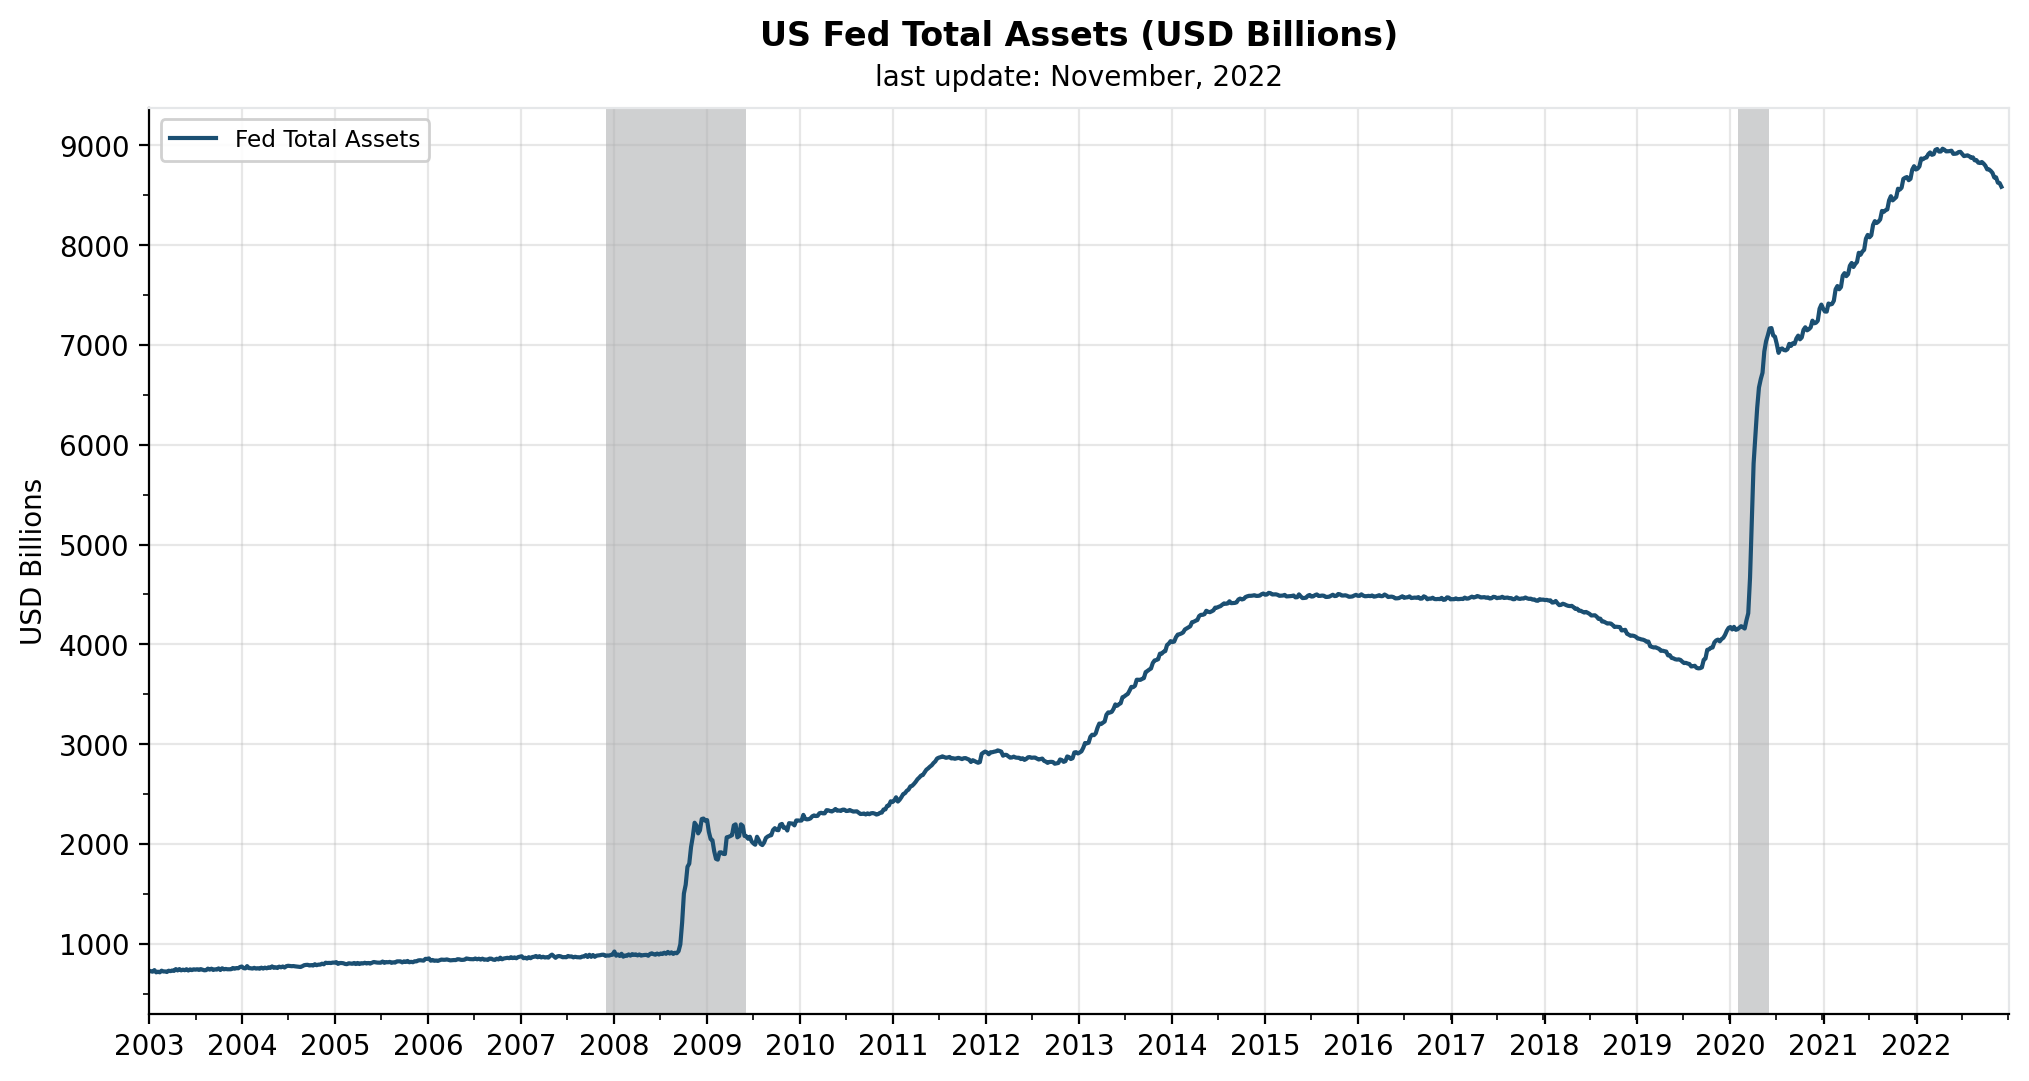

In [44]:
# Fed Total Assets
data = (
    fassets[fassets["series_id"]=="RESPPANWW"]
    .copy()
    .replace("RESPPANWW","Fed Total Assets")
)

data["value"] = data["value"]/1000

# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ['Fed Total Assets'],
    'hue': [colors[0]],
    'alpha':[1],
    'annotation':[False]})

# running function
fig, ax = ts_plot(df = data[["series_id","date","value"]],
                  df_map = df_code,
                  start_date = "2003-01-01",
                  title ='US Fed Total Assets (USD Billions)',
                  ylab='USD Billions',
                  fig_size = (12,6), legend_loc = "upper left",
                  plot_recession = True, plot_zero = False,
                  xmargin = 0.00, ymargin = 0.05,
                  y_major_loc = 1000, y_minor_loc = 2,
                  x_major_loc = 12, x_minor_loc = 2, x_format = "%Y", n=30)

plt.show()

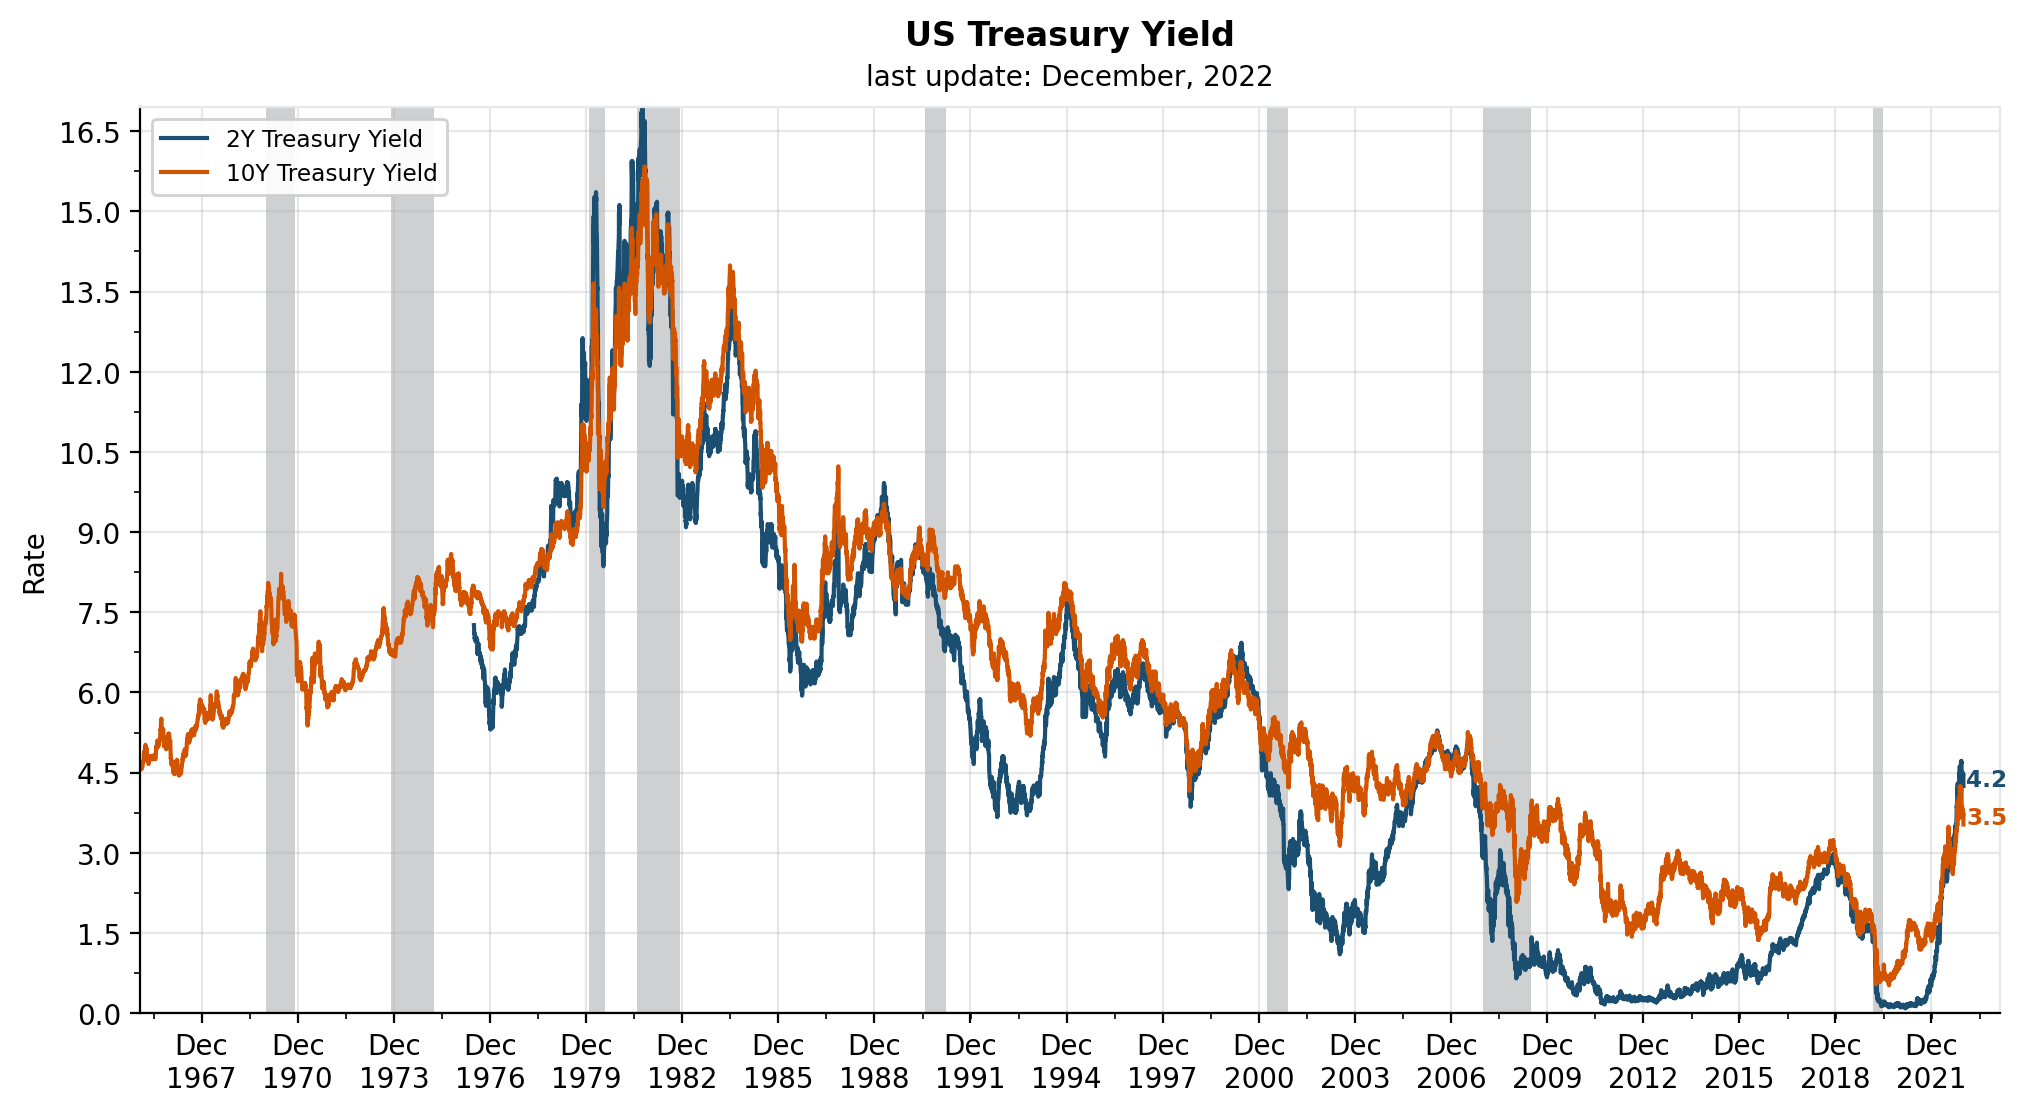

In [60]:
# Fed Treasury Yield
data = (
    treasury[treasury["series_id"].isin(["DGS2","DGS10"])]
    .copy()
    .replace(["DGS2","DGS10"],["2Y Treasury Yield","10Y Treasury Yield"])
)

# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ["2Y Treasury Yield","10Y Treasury Yield"],
    'hue': [colors[0],colors[1]],
    'alpha':[1,1],
    'annotation':[True,True]})

# running function
fig, ax = ts_plot(df = data[["series_id","date","value"]],
                  df_map = df_code,
                  start_date = "1966-01-01",
                  title ='US Treasury Yield',
                  ylab='Rate',
                  fig_size = (12,6), legend_loc = "upper left",
                  plot_recession = True, plot_zero = True,
                  xmargin = 0.00, ymargin = 0.0,
                  y_major_loc = 1.5, y_minor_loc = 2,
                  x_major_loc = 36, x_minor_loc = 2, x_format = "%b\n%Y", n=420)

plt.show()

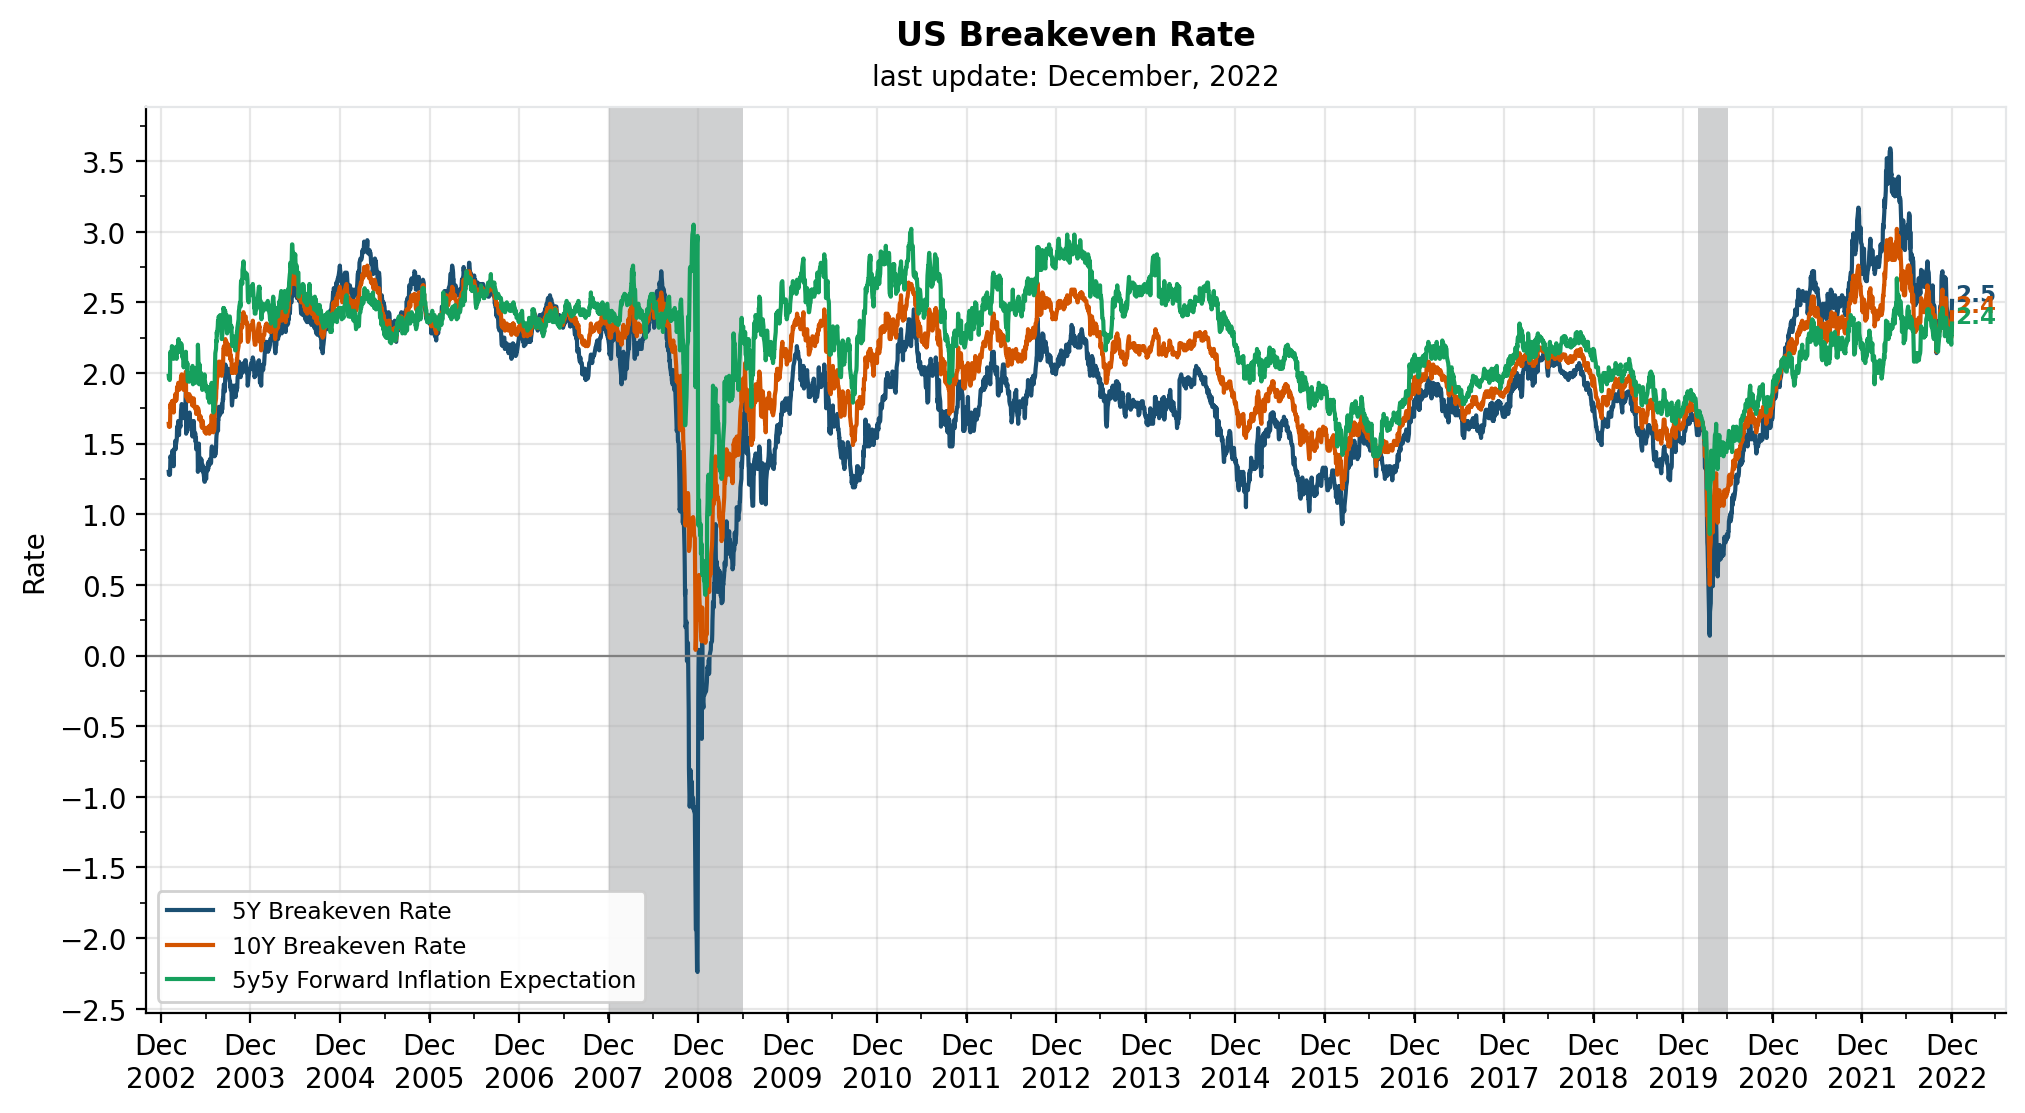

In [79]:
# Breakeven
data = (
    breakeven[breakeven["series_id"].isin(["T5YIE","T10YIE","T5YIFR"])]
    .copy()
    .replace(["T5YIE","T10YIE","T5YIFR"],
             ["5Y Breakeven Rate","10Y Breakeven Rate","5y5y Forward Inflation Expectation"])
)

# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ["5Y Breakeven Rate","10Y Breakeven Rate","5y5y Forward Inflation Expectation"],
    'hue': [colors[0],colors[1],colors[2]],
    'alpha':[1,1,1],
    'annotation':[True,True,True]})

# running function
fig, ax = ts_plot(df = data[["series_id","date","value"]],
                  df_map = df_code,
                  start_date = "2002-10-01",
                  title ='US Breakeven Rate',
                  ylab='Rate',
                  fig_size = (12,6), legend_loc = "lower left",
                  plot_recession = True, plot_zero = True,
                  xmargin = 0.00, ymargin = 0.05,
                  y_major_loc = 0.5, y_minor_loc = 2,
                  x_major_loc = 12, x_minor_loc = 2, x_format = "%b\n%Y", n=220)

plt.show()

In [6]:
snp.head()

,series_id,date,value,series_name
0,GSPC,1927-12-30,17.660000,S&P 500 Index
1,GSPC,1928-01-03,17.760000,S&P 500 Index
2,GSPC,1928-01-04,17.719999,S&P 500 Index
3,GSPC,1928-01-05,17.549999,S&P 500 Index
4,GSPC,1928-01-06,17.660000,S&P 500 Index


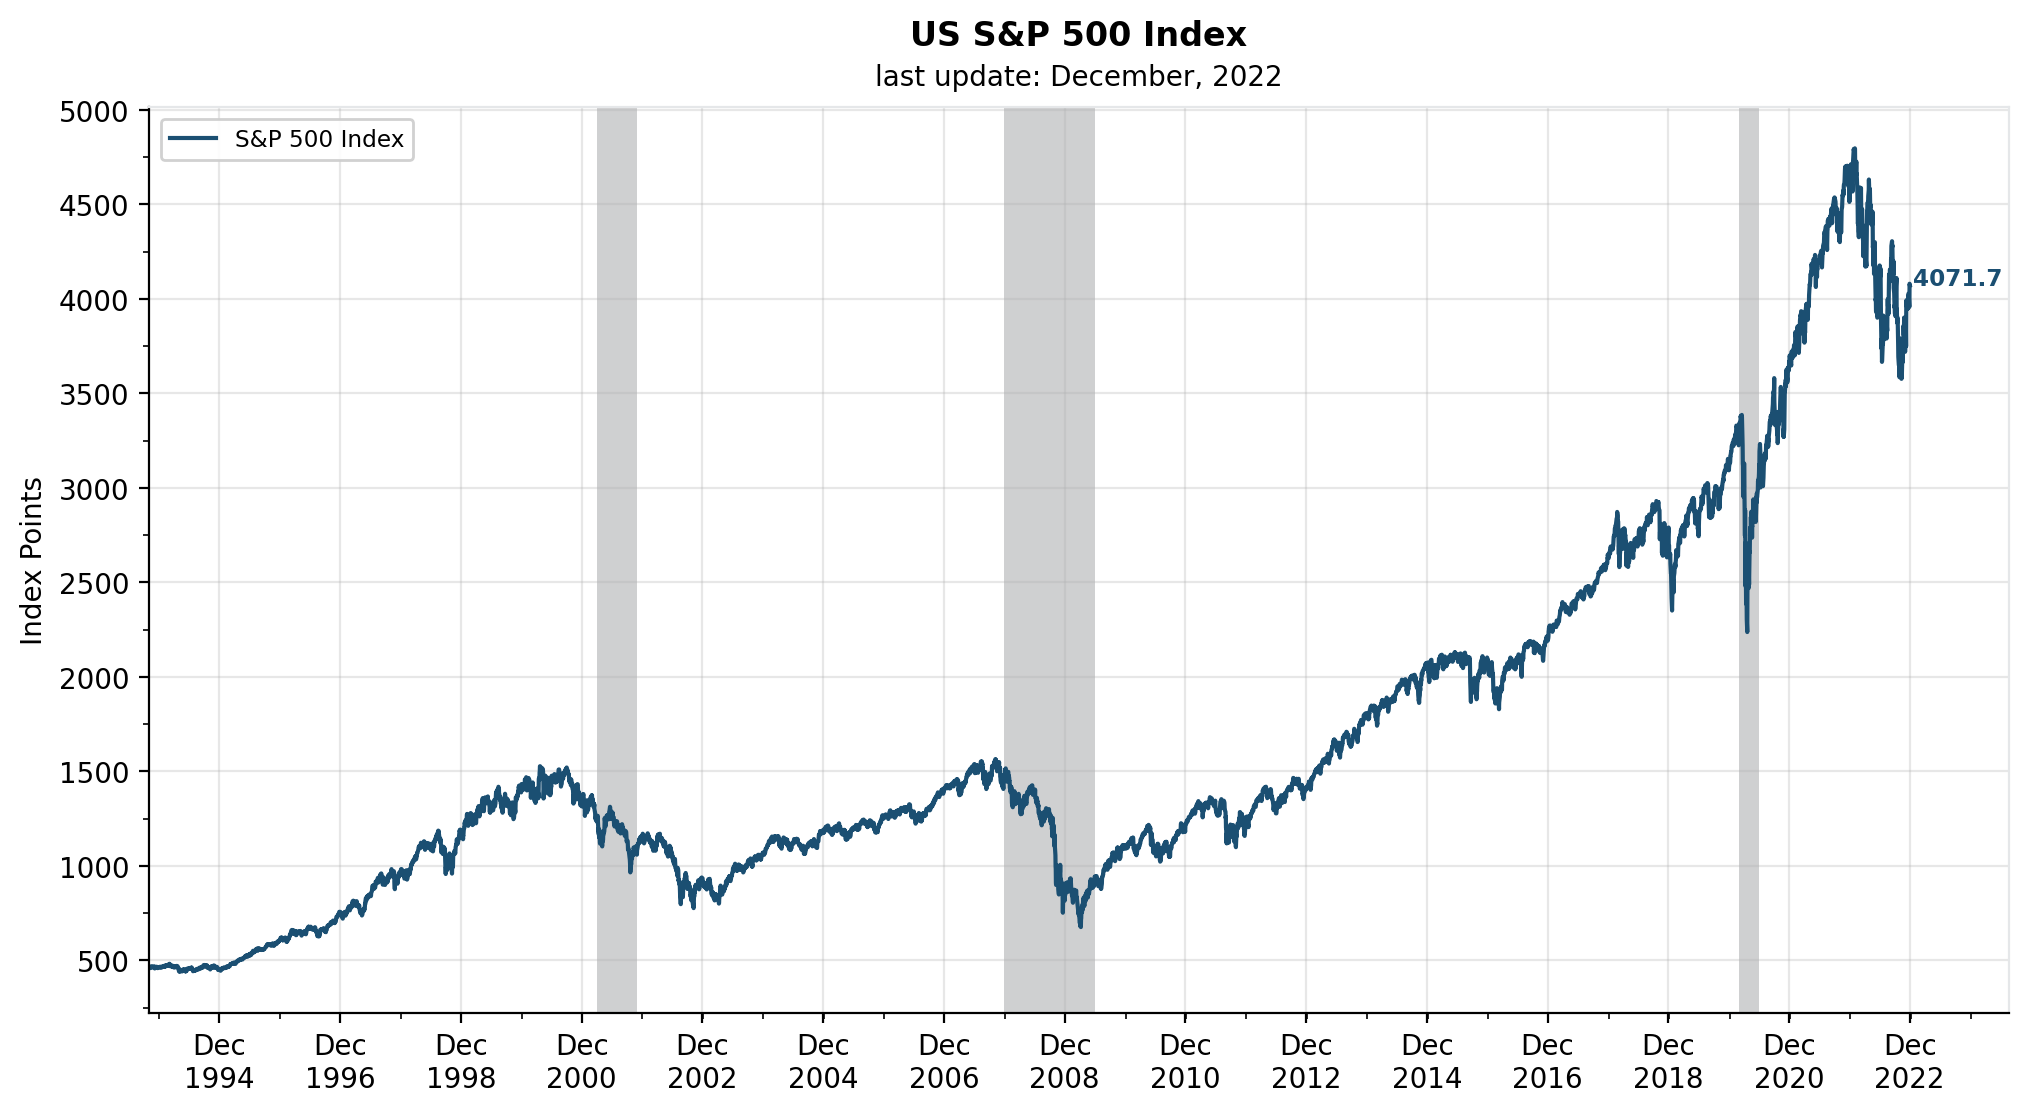

In [22]:
# S&P500
data = (
    snp[snp["series_id"].isin(["GSPC"])]
    .copy()
    .replace(["GSPC"],
             ["S&P 500 Index"])
)

# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ["S&P 500 Index"],
    'hue': [colors[0]],
    'alpha':[1],
    'annotation':[True]})

# running function
fig, ax = ts_plot(df = data[["series_id","date","value"]],
                  df_map = df_code,
                  start_date = "1993-10-01",
                  title ='US S&P 500 Index',
                  ylab='Index Points',
                  fig_size = (12,6), legend_loc = "upper left",
                  plot_recession = True, plot_zero = False,
                  xmargin = 0.00, ymargin = 0.05,
                  y_major_loc = 500, y_minor_loc = 2,
                  x_major_loc = 24, x_minor_loc = 2, x_format = "%b\n%Y", n=600)

plt.show()

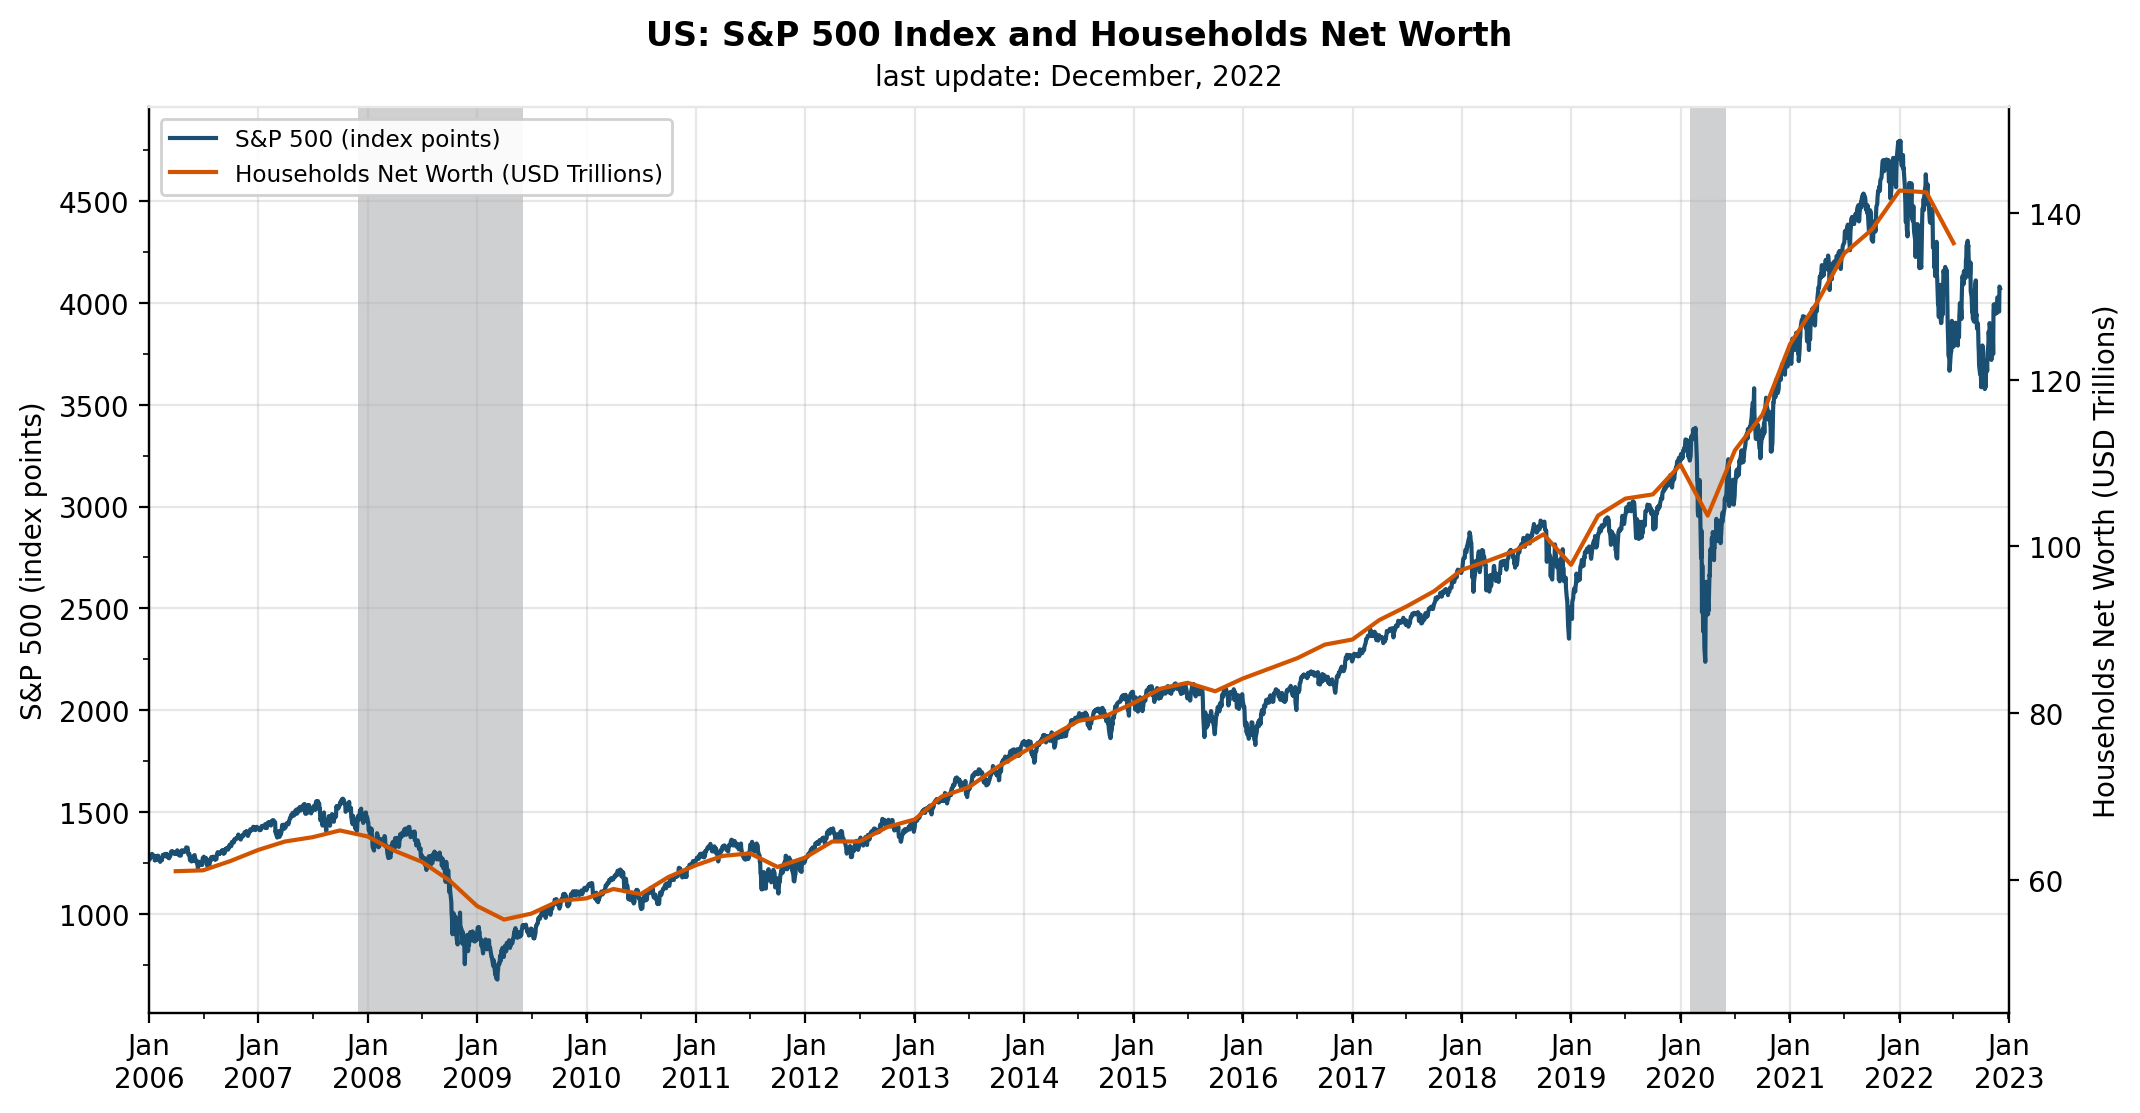

In [37]:
# snp x households net worth
nw = hh_netwoth.copy()[["series_id","date","value"]]
nw["value"] = round(nw["value"]/1000000,1) 
nw["series_id"] = "Households Net Worth (Trillions of Dollars)"
nw["date"] = nw["date"] + pd.DateOffset(months=3)
nw["date"] = nw["date"] - pd.Timedelta(days=1)

fig, ax = dual_ts_plot(df = pd.concat([data, nw]),
                       series1 = "S&P 500 Index", series2 = "Households Net Worth (Trillions of Dollars)",
                       start_date = "2006-01-01",
                       title = "US: S&P 500 Index and Households Net Worth",
                       ly_label = "S&P 500 (index points)",
                       ry_label = "Households Net Worth (USD Trillions)",
                       fig_size = (12,6), legend_loc = "upper left",
                       plot_recession = True, plot_zero = False,
                       xmargin = 0.01, ymargin = 0.04,
                       y_major_loc = 500, y_minor_loc = 2,
                       x_major_loc = 12, x_minor_loc = 2, x_format = "%b\n%Y", n = 30)

plt.show()